# **2023 NFL Big Data Bowl EDA**
### Sol Ben-Ishay

## **Extract+Clean the Data**

In [1]:
# Import libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nfl_data_py as nfl
from utils import animate_play

In [2]:
# Read in the internal BDB competition data
games_df = pd.read_csv("../Data/games.csv")
plays_df = pd.read_csv("../Data/plays.csv")
players_df = pd.read_csv("../Data/players.csv")
scouting_df = pd.read_csv("../Data/pffScoutingData.csv")
tracking_df_list = ["../Data/tracking/week1.csv", "../Data/tracking/week2.csv", "../Data/tracking/week3.csv", "../Data/tracking/week4.csv",
"../Data/tracking/week5.csv", "../Data/tracking/week6.csv", "../Data/tracking/week7.csv", "../Data/tracking/week8.csv"]
tracking_df = pd.concat(map(pd.read_csv, tracking_df_list))

In [3]:
# Read in external nflverse data
# Weekly QBR data
# coi = ['game_id', 'game_week', 'team_abb', 'opp_abb', 'player_id', 'name_display', 'rank', 'qbr_total', 'pts_added',
#        'qb_plays', 'epa_total', 'pass', 'run', 'exp_sack', 'penalty', 'qbr_raw', 'sack', 'name_first', 'name_last',
#        'headshot_href', 'team', 'week_num', 'qualified']
# qbr_df = nfl.import_qbr(years=[2021],frequency='weekly').query("game_week in [1,2,3,4,5,6,7,8]")[coi]

# # Additional play-by-play data
# coi = ['game_id','old_game_id','play_id','week','ep','epa']
# extra_coi = ['total_home_pass_epa','total_away_pass_epa',
# 'total_home_raw_air_epa','total_away_raw_air_epa','total_home_pass_wpa',
# 'total_away_pass_wpa','qb_epa','air_wpa']
# nflverse_pbp_df = nfl.import_pbp_data(years=[2021],columns=coi,include_participation=False,cache=True).query("week in [1,2,3,4,5,6,7,8]")

# nflverse_pbp_df = nflverse_pbp_df.drop(columns=['game_id','week','season'])
# nflverse_pbp_df['old_game_id'] = nflverse_pbp_df['old_game_id'].astype("int")

# nflverse_pbp_df.head()

In [4]:
# Get the play-level data
coi = ['gameId', 'season', 'week', 'homeTeamAbbr', 'visitorTeamAbbr', 'playId',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'foulName1', 'foulNFLId1',
       'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType']
play_level_df = games_df.merge(plays_df, on='gameId', how='left')[coi]

# Replace n/a yardlineSide
play_level_df = play_level_df.fillna(value={'yardlineSide': 'MIDDLE'})

# Drop one play with null absolute yard line number
play_level_df = play_level_df[~((play_level_df.gameId == 2021091904) & (play_level_df.playId == 3676))]

play_level_df.head(5)

,gameId,season,week,homeTeamAbbr,visitorTeamAbbr,playId,playDescription,quarter,down,yardsToGo,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,2021,1,TB,DAL,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,2021,1,TB,DAL,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,2021,1,TB,DAL,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,...,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,2021,1,TB,DAL,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,...,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,2021,1,TB,DAL,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,...,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


In [5]:
# Check for NA data
ok_na_cols = ["penaltyYards", "foulName1", "foulNFLId1", "foulName2", "foulNFLId2",
            "foulName3", "foulNFLId3", "offenseFormation", "personnelO", "defendersInBox",
            "personnelD", "dropBackType"]
if sum(play_level_df.loc[:,~play_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(play_level_df.loc[:,~play_level_df.columns.isin(ok_na_cols)].isna().sum().loc[lambda x: x > 0])

In [6]:
# Get the player-level data
coi = ['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       'pff_role', 'pff_positionLinedUp', 'pff_hit', 'pff_hurry',
       'pff_sack', 'pff_beatenByDefender', 'pff_hitAllowed',
       'pff_hurryAllowed', 'pff_sackAllowed', 'pff_nflIdBlockedPlayer',
       'pff_blockType', 'pff_backFieldBlock']
player_level_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(scouting_df, on=['gameId','playId'], how='left')
                .merge(players_df, on='nflId', how='left'))[coi]
                
player_level_df.head(5)

,gameId,playId,nflId,displayName,officialPosition,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Tom Brady,QB,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Rob Gronkowski,TE,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Antonio Brown,WR,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Giovani Bernard,RB,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Ryan Jensen,C,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [7]:
# Check for NA data
ok_na_cols = ["pff_hit", "pff_hurry", "pff_sack", "pff_beatenByDefender",
            "pff_hitAllowed", "pff_hurryAllowed", "pff_sackAllowed",
            "pff_nflIdBlockedPlayer", "pff_blockType", "pff_backFieldBlock"]
if sum(player_level_df.loc[:,~player_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(player_level_df.isna().sum().loc[lambda x: x > 0])

In [8]:
# Get the frame-level data
coi = ['gameId', 'playId', 'frameId', 'event', 'time', 'nflId', 'displayName', 'team', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']
frame_level_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(tracking_df, on=['gameId','playId'], how='left')
                .merge(players_df, on='nflId', how='left'))[coi]

# Convert dt_time column to time
frame_level_df['time'] = pd.to_datetime(frame_level_df['time'])

# Replace n/a values for ball rows   
frame_level_df = frame_level_df.fillna(value={"nflId":0,"displayName":"ball"})

frame_level_df.head(5)

,gameId,playId,frameId,event,time,nflId,displayName,team,playDirection,x,y,s,a,dis,o,dir
0,2021090900,97,1,None,2021-09-10 00:26:31.100,25511.0,Tom Brady,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99
1,2021090900,97,2,None,2021-09-10 00:26:31.200,25511.0,Tom Brady,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87
2,2021090900,97,3,None,2021-09-10 00:26:31.300,25511.0,Tom Brady,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55
3,2021090900,97,4,None,2021-09-10 00:26:31.400,25511.0,Tom Brady,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85
4,2021090900,97,5,None,2021-09-10 00:26:31.500,25511.0,Tom Brady,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55


In [9]:
# Check for NA data
ok_na_cols = ['o','dir']
if sum(frame_level_df.loc[:,~frame_level_df.columns.isin(ok_na_cols)].isna().sum().values) != 0:
    print(frame_level_df.isna().sum().loc[lambda x: x > 0])

## **Feature Engineering**

### **Snap to Action Time**

*Get the time from snap to an action event for each play for further analyses*

An action event is defined as the earliest of the following:  
  - A throw  
  - A non-throw, but play-ending event (QB sack, strip sack)
  - Any play where the QB doesn't scramble  
  - NOT YET: 3.5 seconds post-snap

A hard time cap is useful for reducing noise introduced by “broken” plays. Plays without a targeted receiver are not used for training, but are included for predictions so that players can be quantified on all pass plays.

In [10]:
# 1. Get the time of all the key events for each play (all individual snap/action events)
potential_snap_events = ['ball_snap', 'autoevent_ballsnap']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
conds = f"(event in {potential_snap_events}) or (event in {potential_action_events})"
coi = ['gameId', 'playId', 'event', 'frameId', 'time']
play_event_times_df = frame_level_df.query(conds)[coi].drop_duplicates()

# 2. Get the time of the snap and action event for each play
# Note: Not distinguishing snap/action times based on if they're from auto/manual events
# Utilizing the times of the earliest snap and earliest action event to calculate the snap to action time.
play_event_times_df.loc[play_event_times_df['event'].isin(potential_snap_events),'event'] = "ballsnap"
play_event_times_df.loc[play_event_times_df['event'].isin(potential_action_events),'event'] = "action"
play_event_times_df = play_event_times_df.groupby(['gameId','playId','event']).min().reset_index().sort_values(by=['time'])

# 3. Drop rows where the tracking data is missing either a snap or action event
bad_rows = (play_event_times_df[['gameId','playId','event']]
            .groupby(['gameId','playId']).count().reset_index()
            .query('event != 2').drop(columns=['event']))
outer = play_event_times_df.merge(bad_rows, on=['gameId','playId'], how='outer', indicator=True)
play_event_times_df = outer[outer._merge == 'left_only'].drop(columns=['_merge'])

# 4. Get the snap to action event time for each play
coi = ['gameId', 'playId', 'time']
snap_to_action_df = play_event_times_df[coi].groupby(['gameId', 'playId']).agg(lambda x: np.max(x) - np.min(x)).reset_index().rename(columns={'time':'snap_to_action_time'})
snap_to_action_df['snap_to_action_time'] = snap_to_action_df['snap_to_action_time'].apply(lambda x: x.total_seconds())
snap_to_action_df = snap_to_action_df.sort_values(by=['snap_to_action_time']).reset_index(drop=True)
snap_to_action_df.head()

,gameId,playId,snap_to_action_time
0,2021100307,2997,0.5
1,2021100304,293,0.5
2,2021103105,2596,0.7
3,2021101707,2181,0.7
4,2021092610,2033,0.8


### **Pass Rushers' Num of Blockers**

In [11]:
# 1. Get the number of blockers per pass rusher on each play
ol = ['C','G','T','TE','RB','FB']
conds = f"pff_role == 'Pass Block' and officialPosition in {ol}"

# 2. Get the blocking assignments of the offensive linemen
coi = ['gameId', 'playId', 'nflId', 'pff_nflIdBlockedPlayer', 'pff_beatenByDefender']
ol_blocks_df = player_level_df.query(conds)[coi]
ol_blocks_df = ol_blocks_df.rename(columns={"nflId":"nflIdBlocker","pff_nflIdBlockedPlayer":"nflIdDefender","pff_beatenByDefender":"beatBlocker"})
ol_blocks_df.head()

# 3. Get the num of blockers per defender
dl_num_blockers_df = ol_blocks_df[['gameId','playId','nflIdDefender','nflIdBlocker']].groupby(['gameId','playId','nflIdDefender']).count().reset_index().rename(columns={'nflIdDefender':'nflId','nflIdBlocker':'numBlockers'})
dl_num_blockers_df.loc[dl_num_blockers_df['numBlockers'] == 1, 'multBlockers'] = "N"
dl_num_blockers_df.loc[dl_num_blockers_df['numBlockers'] > 1, 'multBlockers'] = "Y"
dl_num_blockers_df.head()

,gameId,playId,nflId,numBlockers,multBlockers
0,2021090900,97,42403.0,1,N
1,2021090900,97,44955.0,2,Y
2,2021090900,97,53441.0,2,Y
3,2021090900,137,35441.0,2,Y
4,2021090900,137,35454.0,1,N


### **Pass Rushers' Metrics at 1.5 Seconds After the Snap**

*Get the speed, depth behind the LOS, and straight-line distance of each of the pass rushers from the QB at 1.5 seconds after the snap for each play*

In [12]:
# 1. Get the QB for each play
qb_on_play_df = player_level_df.query("pff_role == 'Pass' and officialPosition == 'QB'")[["gameId","playId","nflId"]]

# 2. Get the position of the QB for each frame
coi = ['gameId', 'playId', 'frameId', 'x', 'y']
qb_pos_df = qb_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]

# 3. Get the pass rushers for each play
pass_rushers_on_play_df = player_level_df.query("officialPosition in ['NT','DT','DE']")[["gameId","playId","nflId"]]

# 4. Get the tracking data of the pass rushers for each frame
coi = ['gameId', 'playId', 'nflId', 'frameId', 'x', 'y', 's', 'playDirection']
pass_rushers_pos_df = pass_rushers_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]

# 5. Get the time of snap for each play
coi = ['gameId','playId','frameId']
time_of_snap_df = play_event_times_df.query("event == 'ballsnap'")[coi]

# 6. Get the position/speed of the QB at 1.5 seconds (15 frames after the snap)
qb_pos_at_key_df = qb_pos_df.merge(time_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
qb_pos_at_key_df = qb_pos_at_key_df.query("frameId == (frameId_snap+15)").drop(columns=["frameId","frameId_snap"])

# 7. Get the position/speed of the pass rushers at 1.5 seconds
pass_rushers_pos_at_key_df = pass_rushers_pos_df.merge(time_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
pass_rushers_pos_at_key_df = pass_rushers_pos_at_key_df.query("frameId == (frameId_snap+15)").drop(columns=["frameId","frameId_snap"])

# 8. Get the depth of the pass rushers at 1.5 seconds
pass_rushers_at_key_df = pass_rushers_pos_at_key_df.merge(play_level_df[['gameId','playId','absoluteYardlineNumber']], on=['gameId','playId'], how='left')
pass_rushers_at_key_df.loc[pass_rushers_at_key_df.playDirection == 'right', 'depth_at_1.5'] = pass_rushers_at_key_df['absoluteYardlineNumber'] - pass_rushers_at_key_df['x']
pass_rushers_at_key_df.loc[pass_rushers_at_key_df.playDirection == 'left', 'depth_at_1.5'] = pass_rushers_at_key_df['x'] - pass_rushers_at_key_df['absoluteYardlineNumber']
pass_rushers_at_key_df = pass_rushers_at_key_df[['gameId','playId','nflId','s','depth_at_1.5']]

# 8. Get the distances of the pass rushers from the QB at 1.5 seconds
rusher_dist_at_key_df = pass_rushers_pos_at_key_df.merge(qb_pos_at_key_df, how='left', on=['gameId','playId'], suffixes=['_pr','_qb'])
rusher_dist_at_key_df['x2-x1'] = (rusher_dist_at_key_df['x_qb'] - rusher_dist_at_key_df['x_pr'])**2
rusher_dist_at_key_df['y2-y1'] = (rusher_dist_at_key_df['y_qb'] - rusher_dist_at_key_df['y_pr'])**2
rusher_dist_at_key_df['distance_at_1.5'] = np.sqrt(rusher_dist_at_key_df['x2-x1'] + rusher_dist_at_key_df['y2-y1'])
rusher_dist_at_key_df = rusher_dist_at_key_df[['gameId','playId','nflId','distance_at_1.5']]

# 9. Get all the metrics of the pass rushers at 1.5 seconds dataframe
pass_rushers_at_key_df = pass_rushers_at_key_df.merge(rusher_dist_at_key_df, on=['gameId','playId','nflId'], how='outer').rename(columns={"s":"speed_at_1.5"})

pass_rushers_at_key_df.head()

,gameId,playId,nflId,speed_at_1.5,depth_at_1.5,distance_at_1.5
0,2021090900,97,41263,4.15,3.03,5.362555
1,2021090900,97,42403,5.21,4.94,6.073986
2,2021090900,97,44955,1.89,2.55,5.720813
3,2021090900,97,53504,2.77,1.88,6.234645
4,2021090900,137,35441,2.75,2.79,4.446268


### **Pass Rushers' Metrics at 2 Seconds After the Snap**

*Get the speed, depth behind the LOS, and straight-line distance of each of the pass rushers from the QB at 2 seconds after the snap for each play*

In [13]:
# 1. Get the position/speed of the QB at 2 seconds (20 frames after the snap)
qb_pos_at_key2_df = qb_pos_df.merge(time_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
qb_pos_at_key2_df = qb_pos_at_key2_df.query("frameId == (frameId_snap+20)").drop(columns=["frameId","frameId_snap"])

# 2. Get the position/speed of the pass rushers at 2 seconds
pass_rushers_pos_at_key2_df = pass_rushers_pos_df.merge(time_of_snap_df, on=['gameId','playId'], how='left', suffixes=['','_snap'])
pass_rushers_pos_at_key2_df = pass_rushers_pos_at_key2_df.query("frameId == (frameId_snap+20)").drop(columns=["frameId","frameId_snap"])

# 3. Get the depth of the pass rushers at 2 seconds
pass_rushers_at_key2_df = pass_rushers_pos_at_key2_df.merge(play_level_df[['gameId','playId','absoluteYardlineNumber']], on=['gameId','playId'], how='left')
pass_rushers_at_key2_df.loc[pass_rushers_at_key2_df.playDirection == 'right', 'depth_at_2'] = pass_rushers_at_key2_df['absoluteYardlineNumber'] - pass_rushers_at_key2_df['x']
pass_rushers_at_key2_df.loc[pass_rushers_at_key2_df.playDirection == 'left', 'depth_at_2'] = pass_rushers_at_key2_df['x'] - pass_rushers_at_key2_df['absoluteYardlineNumber']
pass_rushers_at_key2_df = pass_rushers_at_key2_df[['gameId','playId','nflId','s','depth_at_2']]

# 4. Get the distances of the pass rushers from the QB at 2 seconds
rusher_dist_at_key2_df = pass_rushers_pos_at_key2_df.merge(qb_pos_at_key2_df, how='left', on=['gameId','playId'], suffixes=['_pr','_qb'])
rusher_dist_at_key2_df['x2-x1'] = (rusher_dist_at_key2_df['x_qb'] - rusher_dist_at_key2_df['x_pr'])**2
rusher_dist_at_key2_df['y2-y1'] = (rusher_dist_at_key2_df['y_qb'] - rusher_dist_at_key2_df['y_pr'])**2
rusher_dist_at_key2_df['distance_at_2'] = np.sqrt(rusher_dist_at_key2_df['x2-x1'] + rusher_dist_at_key2_df['y2-y1'])
rusher_dist_at_key2_df = rusher_dist_at_key2_df[['gameId','playId','nflId','distance_at_2']]

# 9. Get all the metrics of the pass rushers at 2 seconds dataframe
pass_rushers_at_key2_df = pass_rushers_at_key2_df.merge(rusher_dist_at_key2_df, on=['gameId','playId','nflId'], how='outer').rename(columns={"s":"speed_at_2"})

pass_rushers_at_key2_df.head()

,gameId,playId,nflId,speed_at_2,depth_at_2,distance_at_2
0,2021090900,97,41263,4.22,4.61,4.200060
1,2021090900,97,42403,4.13,6.75,4.312957
2,2021090900,97,44955,1.41,3.21,6.086156
3,2021090900,97,53504,4.04,3.05,5.741054
4,2021090900,137,35441,2.01,3.97,4.191718


### **Pass Rushers' Time to Depth**

In [14]:
# 1. Set the depth and the condition for when a player is at depth depending on the play direction
depth = 3
right_play_dir_cond = f"(playDirection == 'right') and (x <= absoluteYardlineNumber - {depth})"
left_play_dir_cond = f"(playDirection == 'left') and (x >= absoluteYardlineNumber + {depth})"

# 2. Get all the frames/times at depth for each pass rusher
time_at_depth_df = (play_level_df[['gameId','playId','absoluteYardlineNumber']]
                .merge(frame_level_df, on = ['gameId','playId'], how = 'left')
                .merge(player_level_df[['gameId','playId','nflId', 'officialPosition']], on= ['gameId','playId','nflId'], how='left')
                .query(f"officialPosition in ['NT','DT','DE'] and ({right_play_dir_cond} or {left_play_dir_cond})"))

# 3. Get the minimum frame/time at depth for each pass rusher
coi = ['gameId','playId','nflId', 'displayName', 'time']
min_time_at_depth_df = time_at_depth_df[coi].groupby(['gameId', 'playId', 'nflId', 'displayName']).min().reset_index().rename(columns={'time':'depth_time'})

# 4. Get the time of snap for each play (to calculate the time after snap at depth)
coi = ['gameId','playId','time']
time_of_snap_df = play_event_times_df.query("event == 'ballsnap'")[coi].rename(columns={'time':'snap_time'})

# 5. Get the time after snap to depth for each pass rusher (if they got to depth)
time_to_depth_df = min_time_at_depth_df.merge(time_of_snap_df, on=['gameId','playId'], how='left')
time_to_depth_df["time_to_depth"] = time_to_depth_df['depth_time'] - time_to_depth_df['snap_time']
time_to_depth_df["time_to_depth"] = time_to_depth_df["time_to_depth"].dt.total_seconds()
time_to_depth_df = time_to_depth_df[['gameId', 'playId', 'nflId', 'time_to_depth']].sort_values(by='time_to_depth')

# 6. Drop weird time_to_depth value less than zero (means the player was 3 yds behind the LOS before the snap, bad tracking data?)
time_to_depth_df = time_to_depth_df.query("~(gameId == 2021091204 and playId == 2699 and nflId == 45011)")

time_to_depth_df.head()

,gameId,playId,nflId,time_to_depth
507,2021091201,500,47975.0,0.5
18784,2021102407,3881,47889.0,0.7
17523,2021102400,3971,53540.0,0.8
19780,2021103101,3439,35470.0,0.8
19558,2021103100,1456,47799.0,0.9


### **Pass Rushers' Distance from QB at Release**

*Get the straight-line distance of each of the pass rushers from the QB at the time of release/action event for each play for further analysis with individual OL/DL and Off/Def lines*

In [15]:
# 1. Get the QB for each play
qb_on_play_df = player_level_df.query("pff_role == 'Pass' and officialPosition == 'QB'")[["gameId","playId","nflId"]]

# 2. Get the position of the QB for each frame
coi = ['gameId', 'playId', 'frameId', 'x', 'y']
qb_pos_df = qb_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]

# 3. Get the DL for each play
pass_rushers_on_play_df = player_level_df.query("officialPosition in ['NT','DT','DE']")[["gameId","playId","nflId"]]

# 4. Get the position of the pass rushers for each frame
coi = ['gameId', 'playId', 'nflId', 'frameId', 'x', 'y']
pass_rushers_pos_df = pass_rushers_on_play_df.merge(frame_level_df, on=['gameId','playId','nflId'], how='left')[coi]

# 5. Get the time of release for each play
coi = ['gameId','playId','frameId']
time_of_rel_df = play_event_times_df.query("event == 'action'")[coi]

# 6. Get the position of the QB at release
qb_pos_at_rel_df = time_of_rel_df.merge(qb_pos_df, on=['gameId','playId','frameId'], how='left').drop(columns=['frameId'])

# 7. Get the positions of the pass rushers at release
pass_rushers_pos_at_rel_df = time_of_rel_df.merge(pass_rushers_pos_df, on=['gameId','playId','frameId'], how='left').drop(columns=['frameId'])

# 8. Get the pass rushers distances from qb at release
rusher_dist_at_rel_df = pass_rushers_pos_at_rel_df.merge(qb_pos_at_rel_df, how='left', on=['gameId','playId'], suffixes=['_pr','_qb'])
rusher_dist_at_rel_df['x2-x1'] = (rusher_dist_at_rel_df['x_qb'] - rusher_dist_at_rel_df['x_pr'])**2
rusher_dist_at_rel_df['y2-y1'] = (rusher_dist_at_rel_df['y_qb'] - rusher_dist_at_rel_df['y_pr'])**2
rusher_dist_at_rel_df['distance_at_rel'] = np.sqrt(rusher_dist_at_rel_df['x2-x1'] + rusher_dist_at_rel_df['y2-y1'])
rusher_dist_at_rel_df = rusher_dist_at_rel_df[['gameId', 'playId', 'nflId', 'distance_at_rel']]
rusher_dist_at_rel_df.head()

,gameId,playId,nflId,distance_at_rel
0,2021090900,97,41263.0,3.238673
1,2021090900,97,42403.0,3.805391
2,2021090900,97,44955.0,10.437672
3,2021090900,97,53504.0,2.496498
4,2021090900,137,35441.0,3.635505


### **Pass Rushers' Pressures**

In [16]:
# Get whether the pass rusher got a pressure on the play
dl = ['NT','DT','DE']
conds = f"officialPosition in {dl}"

coi = ['gameId', 'playId', 'nflId', 'pff_sack', 'pff_hit', 'pff_hurry']
dl_pressure_df = player_level_df.query(conds)[coi]
dl_pressure_df['pressureOnPlay'] = dl_pressure_df.loc[:,["pff_sack","pff_hit","pff_hurry"]].sum(axis=1)
dl_pressure_df = dl_pressure_df.drop(columns=['pff_sack','pff_hit','pff_hurry'])
dl_pressure_df.head()

,gameId,playId,nflId,pressureOnPlay
6,2021090900,97,41263,1.0
8,2021090900,97,42403,1.0
14,2021090900,97,44955,0.0
21,2021090900,97,53504,1.0
22,2021090900,137,35441,0.0


## **Offensive Line Analysis**

### **Individual**

#### **Quarterbacks**

In [17]:
# Get the plays for QBs who played more than 30 snaps
coi = ['gameId','playId','nflId','displayName','officialPosition']
high_snap_qbs = player_level_df.query("officialPosition == 'QB'").nflId.value_counts().loc[lambda c: c > 30].index.tolist()
qb_df = player_level_df[coi].query(f"nflId in {high_snap_qbs}")

qb_df.head()

,gameId,playId,nflId,displayName,officialPosition
0,2021090900,97,25511,Tom Brady,QB
31,2021090900,137,43424,Dak Prescott,QB
51,2021090900,187,43424,Dak Prescott,QB
75,2021090900,282,43424,Dak Prescott,QB
96,2021090900,349,43424,Dak Prescott,QB


In [18]:
# Average snap to action times by QBs
qb_avg_rel_time_df = qb_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')
qb_avg_rel_time_df = qb_avg_rel_time_df[["displayName","snap_to_action_time"]].groupby("displayName").mean().sort_values(by=['snap_to_action_time'],ascending=[True]).reset_index()
qb_avg_rel_time_df.head()

,displayName,snap_to_action_time
0,Ben Roethlisberger,2.661765
1,Mike White,2.697368
2,Tom Brady,2.787908
3,Cooper Rush,2.793478
4,Mac Jones,2.820641


In [19]:
# Pass result counts by QB
qb_pass_results = qb_df.merge(play_level_df[['gameId','playId','passResult']], on = ['gameId', 'playId'], how='left')
qb_pass_results.head()

qb_pass_result_counts = (qb_pass_results[["displayName", "passResult"]]
                    .groupby(["displayName","passResult"])
                    .value_counts().reset_index(name="count").sort_values(by=["passResult", "count"], ascending=[True, False]))
qb_pass_result_counts.head()

,displayName,passResult,count
74,Jared Goff,C,189
173,Tom Brady,C,179
124,Matt Ryan,C,176
119,Mac Jones,C,170
138,Patrick Mahomes,C,167


### **Team**

In [20]:
# Get the play-level OL relevant data only for plays with QBs who played more than 30 snaps (to account for outlying events such as when a typical starter is injured)
# high_snap_qbs = player_level_df.query("officialPosition == 'QB'").nflId.value_counts().loc[lambda c: c > 30].index.tolist()
coi = ['gameId', 'playId', 'possessionTeam', 'passResult', 'prePenaltyPlayResult']
ol_df = play_level_df[coi]
ol_df = ol_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

ol_df.head()

,gameId,playId,possessionTeam,passResult,prePenaltyPlayResult,snap_to_action_time
0,2021090900,97,TB,I,0,3.2
1,2021090900,137,DAL,C,28,2.6
2,2021090900,187,DAL,C,5,2.0
3,2021090900,282,DAL,I,0,3.2
4,2021090900,349,DAL,I,0,2.6


#### **Descriptive Statistics**

In [21]:
# Two-way descriptive statistics
pass_res_des_stats = ol_df[["passResult", "prePenaltyPlayResult", "snap_to_action_time"]].groupby("passResult")[["snap_to_action_time", "prePenaltyPlayResult"]].describe()
pass_res_des_stats

snap_to_action_time                                                \
                         count      mean       std  min  25%  50%  75%   max   
passResult                                                                     
C                       4604.0  2.800500  1.020795  0.5  2.2  2.6  3.2  17.1   
I                       2750.0  3.187855  1.297617  0.5  2.4  2.9  3.6  19.2   
IN                       189.0  3.315873  1.096785  0.7  2.6  3.1  3.6   7.3   
R                        447.0  4.306711  1.228747  1.4  3.4  4.2  4.9   8.7   
S                        542.0  4.421033  1.212763  1.0  3.6  4.3  5.0   9.6   

           prePenaltyPlayResult                                              \
                          count       mean        std   min  25%  50%   75%   
passResult                                                                    
C                        4619.0  12.114960  10.350233  -8.0  6.0  9.0  15.0   
I                        2755.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
IN                        190.0   0.000000   0.000000   0.0  0.0  0.0   0.0   
R                         449.0   7.719376   6.121654   1.0  4.0  6.0  10.0   
S                         543.0  -7.016575   3.817529 -34.0 -9.0 -7.0  -5.0   

                  
             max  
passResult        
C           91.0  
I            0.0  
IN           0.0  
R           39.0  
S            0.0

#### **Exploratory Plots**

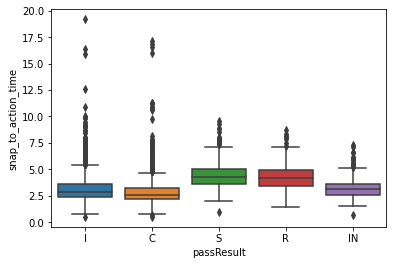

In [22]:
# Boxplot of the snap to action time vs pass result
box = sns.boxplot(data=ol_df, x="passResult", y="snap_to_action_time")
plt.show()

## **Defensive Line Analysis**

### **Individual**

In [23]:
## Get the player-level DL relevant data
# Note: For players who pass rushed more than 35 snaps and for plays their role was "Pass Rush" (to account for noise)
# Note: potentially consider OLB in DL
high_snap_pass_rushers = player_level_df.query("officialPosition in ['NT','DT','DE'] and pff_role == 'Pass Rush'").nflId.value_counts().loc[lambda c: c > 35].index.tolist()
coi = ['gameId', 'playId', 'nflId', 'displayName', 'officialPosition',
       'pff_role', 'pff_positionLinedUp', 'pff_hit', 'pff_hurry', 'pff_sack']
dl_df = (player_level_df[coi].query(f"nflId in {high_snap_pass_rushers} and pff_role == 'Pass Rush'")
        .merge(play_level_df[['gameId','playId','passResult']], how='left', on=['gameId','playId'])
        .merge(snap_to_action_df, how='left', on=['gameId','playId'])
        .merge(rusher_dist_at_rel_df, how='left', on=['gameId','playId','nflId'])
        .merge(pass_rushers_at_key_df, how='left', on=['gameId','playId','nflId'])
        .merge(pass_rushers_at_key2_df, how='left', on=['gameId','playId','nflId'])
        .merge(time_to_depth_df, how='left', on=['gameId','playId','nflId'])
        .merge(dl_num_blockers_df, how='left', on=['gameId','playId','nflId']))

# Get whether the player got a pressure on the play
dl_df['pff_pressure'] = dl_df[['pff_hit','pff_hurry','pff_sack']].sum(axis=1)

## Clean up NAs
# A missing snap_to_action_time/distance at rel occurs when a certain play is missing either a snap or action event
dl_df = dl_df.dropna(subset=['snap_to_action_time','distance_at_rel'], how='any')
# numBlockers and multBlockers is N/A when a player is unblocked
dl_df = dl_df.fillna(value={'numBlockers':0,'multBlockers':'U'})

## Filter plays
# Only look at plays that were either C, I, S, or IN (no scrambles, laterals, etc)
dl_df = dl_df.query("passResult in ['C','I','S','IN','R']")
#  Only look at plays that have a snap to action time within the 95th percentile
dl_df = dl_df[dl_df.snap_to_action_time < dl_df.snap_to_action_time.quantile(.95)]

dl_df.head()

,gameId,playId,nflId,displayName,officialPosition,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,...,speed_at_1.5,depth_at_1.5,distance_at_1.5,speed_at_2,depth_at_2,distance_at_2,time_to_depth,numBlockers,multBlockers,pff_pressure
0,2021090900,97,42403,Randy Gregory,DE,Pass Rush,ROLB,0.0,1.0,0.0,...,5.21,4.94,6.073986,4.13,6.75,4.312957,1.1,1.0,N,1.0
1,2021090900,97,44955,Carlos Watkins,DE,Pass Rush,DRT,0.0,0.0,0.0,...,1.89,2.55,5.720813,1.41,3.21,6.086156,1.8,2.0,Y,0.0
2,2021090900,97,53504,Osa Odighizuwa,DT,Pass Rush,RE,0.0,1.0,0.0,...,2.77,1.88,6.234645,4.04,3.05,5.741054,2.0,0.0,U,1.0
3,2021090900,137,35441,Ndamukong Suh,DE,Pass Rush,DRT,0.0,0.0,0.0,...,2.75,2.79,4.446268,2.01,3.97,4.191718,1.6,2.0,Y,0.0
4,2021090900,137,35454,Jason Pierre-Paul,DE,Pass Rush,ROLB,0.0,0.0,0.0,...,3.62,2.24,5.298726,2.39,3.18,5.019691,1.9,1.0,N,0.0


In [24]:
# Check for NAs
# A missing time_to_depth occurs when the rusher did not make it to 3 yards
# Missing metrics at 2 seconds indicate plays that did not last 2 seconds (maybe should filter out?)
if sum(dl_df.isna().sum().values) != 0:
    print(dl_df.isna().sum().loc[lambda x: x > 0])

speed_at_2        108
depth_at_2        108
distance_at_2     108
time_to_depth    3489
dtype: int64


#### **Descriptive Statistics/Exploratory Plots**

In [25]:
# Descriptive statistics
coi = ["snap_to_action_time", "pff_hit", "pff_hurry", "pff_sack", "pff_pressure", "distance_at_rel",
 "distance_at_1.5", "depth_at_1.5", "speed_at_1.5", "distance_at_2", "depth_at_2", "speed_at_2", "time_to_depth", "numBlockers"]
dl_df[coi].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
snap_to_action_time,23633.0,2.925299,0.862356,0.500000,2.300000,2.800000,3.400000,5.400000
pff_hit,23633.0,0.019253,0.137415,0.000000,0.000000,0.000000,0.000000,1.000000
pff_hurry,23633.0,0.063598,0.244040,0.000000,0.000000,0.000000,0.000000,1.000000
pff_sack,23633.0,0.011552,0.106858,0.000000,0.000000,0.000000,0.000000,1.000000
pff_pressure,23633.0,0.094402,0.292393,0.000000,0.000000,0.000000,0.000000,1.000000
distance_at_rel,23633.0,5.005908,3.128369,0.040000,3.287324,4.365375,5.682051,39.241072
distance_at_1.5,23633.0,5.374922,0.963498,1.127298,4.756848,5.313718,5.923462,11.608794
depth_at_1.5,23633.0,2.411829,1.281167,-1.610000,1.560000,2.360000,3.250000,7.860000
speed_at_1.5,23633.0,3.081584,1.105890,0.000000,2.330000,3.050000,3.830000,6.640000
distance_at_2,23525.0,5.263221,1.466868,0.454533,4.282347,5.095498,6.066366,13.930790


In [26]:
# Descriptive statistics grouped by pressureOnPlay (either pff sack, hit, or hurry)
coi = ["pff_pressure", "distance_at_1.5", "depth_at_1.5", "speed_at_1.5", "distance_at_2", "depth_at_2", "speed_at_2", "time_to_depth"]
dl_df[coi].groupby('pff_pressure').describe().transpose()

pff_pressure                    0.0          1.0
distance_at_1.5 count  21402.000000  2231.000000
                mean       5.401189     5.122940
                std        0.957830     0.981385
                min        1.736001     1.127298
                25%        4.782489     4.486167
                50%        5.334899     5.122577
                75%        5.941368     5.701754
                max       11.608794    10.000290
depth_at_1.5    count  21402.000000  2231.000000
                mean       2.361748     2.892255
                std        1.275188     1.238477
                min       -1.610000    -0.760000
                25%        1.500000     2.020000
                50%        2.320000     2.810000
                75%        3.180000     3.760000
                max        7.860000     6.940000
speed_at_1.5    count  21402.000000  2231.000000
                mean       3.029629     3.579982
                std        1.098272     1.053687
                min        0.000000     0.140000
                25%        2.290000     2.875000
                50%        3.000000     3.550000
                75%        3.770000     4.250000
                max        6.480000     6.640000
distance_at_2   count  21296.000000  2229.000000
                mean       5.348020     4.453047
                std        1.456851     1.306594
                min        0.927631     0.454533
                25%        4.364737     3.577625
                50%        5.162407     4.405916
                75%        6.133256     5.294308
                max       13.930790     9.637282
depth_at_2      count  21296.000000  2229.000000
                mean       3.564441     4.512140
                std        1.766766     1.584721
                min       -2.020000    -0.870000
                25%        2.430000     3.430000
                50%        3.490000     4.480000
                75%        4.690000     5.600000
                max        9.790000     8.990000
speed_at_2      count  21296.000000  2229.000000
                mean       2.653925     3.543751
                std        1.112099     1.066616
                min        0.010000     0.150000
                25%        1.860000     2.860000
                50%        2.590000     3.520000
                75%        3.400000     4.260000
                max        7.280000     7.460000
time_to_depth   count  17924.000000  2220.000000
                mean       1.815376     1.679324
                std        0.535437     0.465018
                min        0.500000     0.800000
                25%        1.400000     1.400000
                50%        1.700000     1.600000
                75%        2.100000     1.900000
                max        5.800000     4.900000

<AxesSubplot: xlabel='pff_pressure', ylabel='speed_at_1.5'>

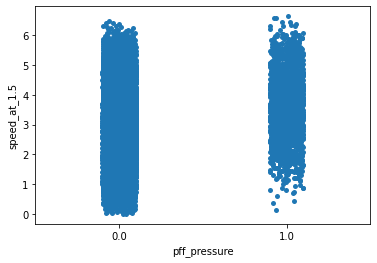

In [27]:
# Depth at 2 vs pressureOnPlay
sns.stripplot(dl_df, x="pff_pressure", y="speed_at_1.5")

<AxesSubplot: xlabel='pff_pressure', ylabel='speed_at_2'>

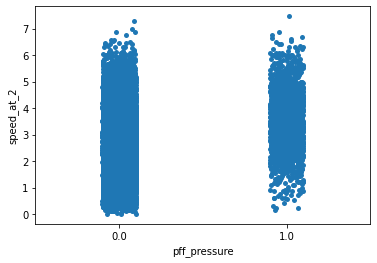

In [28]:
# Distance at 2 vs pressureOnPlay
sns.stripplot(dl_df, x="pff_pressure", y="speed_at_2")

#### **Player-level Frequencies**

In [29]:
# Two-way frequency table (multiple blockers and pff pressure)
pd.crosstab(index=dl_df['multBlockers'], columns=dl_df['pff_pressure'], normalize='index')

pff_pressure,0.0,1.0
multBlockers,,
N,0.887146,0.112854
U,0.823581,0.176419
Y,0.946358,0.053642


In [30]:
# Frequencies of multBlockers on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'multBlockers']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['multBlockers','%'],ascending=[False,False])
.head(5))

,nflId,displayName,officialPosition,multBlockers,%
394,46618,Taylor Stallworth,DT,Y,0.675000
236,43638,Justin Zimmer,DT,Y,0.670588
63,39960,Star Lotulelei,DT,Y,0.663366
19,35522,Corey Peters,DT,Y,0.657143
54,38619,Akiem Hicks,DT,Y,0.642105


In [31]:
# Frequencies of pressureOnPlay on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'pff_pressure']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['pff_pressure','%'],ascending=[False,False])
.head(5))

,nflId,displayName,officialPosition,pff_pressure,%
311,47889,Maxx Crosby,DE,1.0,0.213592
179,44813,Myles Garrett,DE,1.0,0.210256
11,35470,Jerry Hughes,DE,1.0,0.198413
206,44915,Trey Hendrickson,DE,1.0,0.196970
99,42403,Randy Gregory,DE,1.0,0.187050


In [32]:
# Frequencies of multBlockers/pressureOnPlay on passing plays grouped by player
coi = ['nflId', 'displayName', 'officialPosition', 'multBlockers','pff_pressure']

(dl_df[coi]
.groupby(['nflId', 'displayName', 'officialPosition'])
.value_counts(normalize=True)
.reset_index(name='%')
.sort_values(by=['pff_pressure','%'],ascending=[False,False])
.head(5))


,nflId,displayName,officialPosition,multBlockers,pff_pressure,%
26,35470,Jerry Hughes,DE,N,1.0,0.174603
437,44813,Myles Garrett,DE,N,1.0,0.164103
509,44915,Trey Hendrickson,DE,N,1.0,0.156566
778,47889,Maxx Crosby,DE,N,1.0,0.150485
885,52462,A.J. Epenesa,DE,N,1.0,0.148148


#### **Player-level Average Statistics**

In [33]:
# Player-level average statistics (on plays they got pressures to see if their is a visually evident relationship with any features)
coi = ['nflId', 'displayName', 'officialPosition', 'pff_hit', 'pff_hurry',
    'pff_sack', 'pff_pressure', 'distance_at_rel', 'distance_at_1.5',
    'depth_at_1.5', 'speed_at_1.5', 'distance_at_2', 'depth_at_2', 'speed_at_2',
    'time_to_depth', 'numBlockers']

indy_dl_avg_df = dl_df[coi].groupby(['nflId', 'displayName', 'officialPosition']).mean().reset_index()

indy_dl_avg_df.sort_values(by=['distance_at_2','speed_at_2'], ascending=[True, True]).head(10)

,nflId,displayName,officialPosition,pff_hit,pff_hurry,pff_sack,pff_pressure,distance_at_rel,distance_at_1.5,depth_at_1.5,speed_at_1.5,distance_at_2,depth_at_2,speed_at_2,time_to_depth,numBlockers
76,43358,Yannick Ngakoue,DE,0.031579,0.094737,0.021053,0.147368,3.974127,5.015479,4.115053,4.187263,4.238851,5.857672,3.524868,1.342623,1.010526
89,44813,Myles Garrett,DE,0.046154,0.123077,0.041026,0.210256,4.346014,5.300203,3.841282,4.073744,4.549193,5.388763,3.465206,1.414439,1.123077
79,43378,Javon Hargrave,DT,0.036364,0.090909,0.030303,0.157576,4.084931,4.670862,2.359030,2.704606,4.577651,3.565273,2.511273,1.749242,1.569697
143,47787,Clelin Ferrell,DE,0.020408,0.081633,0.000000,0.102041,4.371946,5.249168,3.629388,3.914694,4.592136,5.262857,3.479796,1.458333,1.020408
142,47786,Quinnen Williams,NT,0.020134,0.087248,0.026846,0.134228,4.706534,4.663267,2.191611,2.827919,4.667353,3.278993,2.491946,1.813559,1.416107
130,46199,Josh Sweat,DE,0.024845,0.080745,0.031056,0.136646,3.982746,5.454301,3.563540,4.003354,4.696400,5.235093,3.448012,1.480645,1.024845
49,42403,Randy Gregory,DE,0.050360,0.100719,0.035971,0.187050,4.340388,5.394498,3.147698,3.931079,4.699955,4.709712,3.472158,1.600741,1.007194
199,53053,Bryce Huff,DE,0.037594,0.060150,0.030075,0.127820,4.611611,5.356279,3.423985,3.911955,4.739721,5.006541,3.296466,1.496154,1.022556
32,41239,Aaron Donald,DT,0.029046,0.091286,0.012448,0.132780,4.722844,5.030540,2.917884,3.329876,4.749505,4.275500,2.950125,1.605116,1.535270
93,44838,Takkarist McKinley,DE,0.026316,0.052632,0.017544,0.096491,4.511288,5.661302,3.370263,4.177982,4.774042,4.973509,3.753772,1.532727,1.096491


#### **Player-level Cumulative Statistics**

In [34]:
indy_dl_cum_df = (dl_df[['nflId','displayName','officialPosition','pff_hit','pff_hurry','pff_sack','pff_pressure']].groupby(['nflId','displayName','officialPosition']).sum().sort_values(by=['pff_pressure'],ascending=[False]))
indy_dl_cum_df

,,,pff_hit,pff_hurry,pff_sack,pff_pressure
nflId,displayName,officialPosition,,,,
47889,Maxx Crosby,DE,12.0,27.0,5.0,44.0
44813,Myles Garrett,DE,9.0,24.0,8.0,41.0
44915,Trey Hendrickson,DE,6.0,25.0,8.0,39.0
41239,Aaron Donald,DT,7.0,22.0,3.0,32.0
44829,Jonathan Allen,DT,8.0,16.0,6.0,30.0
...,...,...,...,...,...,...
44905,Montravius Adams,DE,0.0,0.0,0.0,0.0
52582,Larrell Murchison,DT,0.0,0.0,0.0,0.0
46438,Tyler Lancaster,NT,0.0,0.0,0.0,0.0


## **Desriptive Performance Metrics**

## **ML Models**

In [35]:
# Code snippet to train/test a classification model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

def run_experiment(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

### **Predict whether a player will get a pressure on a play**

In [36]:
# Get the training/test data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Model Data w N/As dropped for model
model_df = dl_df.dropna()
model_df.head()

# Features
feature_cols = [
       # 'officialPosition', 'pff_role', 'pff_positionLinedUp',
       'speed_at_1.5', 'depth_at_1.5', 'distance_at_1.5',
       'speed_at_2', 'depth_at_2', 'distance_at_2',
       'time_to_depth', 'numBlockers']
features = model_df[feature_cols]

# Target
target = model_df['pff_pressure']

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle=True)

# Balance the sample of training data with/without a pressure
under_sampler = RandomUnderSampler(random_state=77)
x_train, y_train = under_sampler.fit_resample(x_train, y_train)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

x_train.head()

Training target statistics: Counter({0.0: 1785, 1.0: 1785})
Testing target statistics: Counter({0.0: 3585, 1.0: 434})


,speed_at_1.5,depth_at_1.5,distance_at_1.5,speed_at_2,depth_at_2,distance_at_2,time_to_depth,numBlockers
0,2.94,2.77,5.582517,2.16,4.08,5.304046,1.6,1.0
1,4.06,1.24,6.392011,2.67,2.38,6.443105,2.5,0.0
2,2.85,1.78,4.821214,2.16,2.95,4.626230,2.1,1.0
3,1.94,2.23,6.211811,1.40,2.64,6.338344,2.6,2.0
4,2.02,0.35,5.632273,2.68,1.62,6.865166,2.6,2.0


Model Results:


,Model Name,Precision,Recall,F1,Accuracy
0,Decision Tree,0.150966,0.576037,0.239234,0.604379
1,kNN (k=5),0.176817,0.622120,0.275370,0.646429
2,kNN (k=7),0.183278,0.631336,0.284085,0.656382
3,kNN (k=9),0.184761,0.631336,0.285863,0.659368


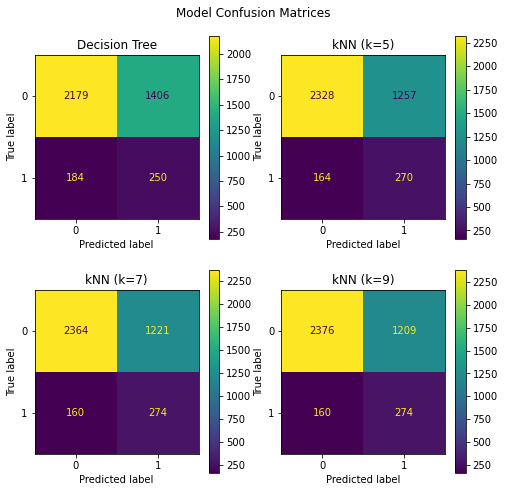

In [37]:
# Train, test, and evaluate different classification models
from sklearn import tree
from sklearn import neighbors
from IPython.display import display

# Classification models to experiment
decision_tree_models = {"Decision Tree":tree.DecisionTreeClassifier()}
knn_models = {"kNN (k=5)":neighbors.KNeighborsClassifier(n_neighbors=5),
            "kNN (k=7)":neighbors.KNeighborsClassifier(n_neighbors=7),
            "kNN (k=9)":neighbors.KNeighborsClassifier(n_neighbors=9)}
models = decision_tree_models | knn_models

# Function to run experiments with multiple classification models
def run_experiments(models, X_train, y_train, X_test, y_test):
    with plt.ioff():
        # Create the performance results dictionary and main plot
        results = {"Model Name":[],"Precision":[],"Recall":[],"F1":[],"Accuracy":[]}
        confusion_matrices, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
        confusion_matrices.suptitle("Model Confusion Matrices")
        confusion_matrices.tight_layout()

        for model_name, ax in zip(list(models.keys()), axs.ravel()):
            # Train/test the model
            model = models[model_name]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Create a confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=ax)
            ax.title.set_text(model_name)

            # Append the performance results
            results['Model Name'].append(model_name)
            results['Precision'].append(precision_score(y_test, y_pred))
            results['Recall'].append(recall_score(y_test, y_pred))
            results['F1'].append(f1_score(y_test, y_pred))
            results['Accuracy'].append(accuracy_score(y_test, y_pred))

        # Show the performance metrics and plot the confusion matrices
        print("Model Results:")
        results_df = pd.DataFrame(results).style.set_caption("Model Performance Metrics")
        display(results_df)
        print()
        plt.show()

run_experiments(models, x_train, y_train, x_test, y_test)